In [1]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.run_functions_eagerly(True)

# Random Seed
random_seed = 12345

In [2]:
# import tensorflow as tf
# print(tf.config.list_physical_devices(device_type=None))
print(tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device Details: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install Tensorflow that supports GPU")

2.10.1
Default GPU Device Details: /device:GPU:0


# Split the dataset into training and test set

In [3]:

# Set the datapaths
imagepath = '../data/machined/cleanData/NiclaVision/'
testpath = imagepath + 'test/'
trainpath = imagepath + 'train/'
valpath = imagepath + 'validation/'
os.makedirs(testpath, exist_ok=True)
os.makedirs(trainpath, exist_ok=True)
os.makedirs(valpath, exist_ok=True)


# Split the dataset into training+validation and test
random_seed = 12345
df = pd.read_csv(f'../data/machined/metadata_normalized.csv')
# Grab 10% of the data to use as a test set, the random seed will make sure this is the same throughout the initial testing
test_df = df.sample(frac = 0.1, replace = False, random_state = random_seed).sort_values(by=['TimeStamp'])

# Make a copy of dataset and remove the test data.
trainVal_df = df.copy().drop(test_df.index)
val_df = trainVal_df.sample(frac = 0.1, replace = False, random_state = random_seed).sort_values(by=['TimeStamp'])
train_df = trainVal_df.copy().drop(val_df.index).sort_values(by=['TimeStamp'])


# Copy the test images to a new "test"-folder
for name in tqdm(test_df.loc[:]["TimeStamp"]):
    image = str(name) + '.jpeg'
    currentPath = os.path.join(imagepath, image)
    newPath = os.path.join(testpath, image)
    if not os.path.exists(newPath):
        shutil.move(currentPath, newPath)

# Copy the training images to a new "train"-folder
for name in tqdm(train_df.loc[:]["TimeStamp"]):
    image = str(name) + '.jpeg'
    currentPath = os.path.join(imagepath, image)
    newPath = os.path.join(trainpath, image)
    if not os.path.exists(newPath):
        shutil.move(currentPath, newPath)

# Copy the validation images to a new "validation"-folder
for name in tqdm(val_df.loc[:]["TimeStamp"]):
    image = str(name) + '.jpeg'
    currentPath = os.path.join(imagepath, image)
    newPath = os.path.join(valpath, image)
    if not os.path.exists(newPath):
        shutil.move(currentPath, newPath)

100%|██████████| 1459/1459 [00:00<00:00, 1722.23it/s]


## Import the datasets and set configs

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 4096
BATCH_SIZE = 1024
IMG_W = 45#120/2
IMG_H = 30 #80/2
CHANNELS = 1
FILENAME = f'machined_{IMG_W}x{IMG_H}_hpsearch'

In [5]:


def getImageFileNames(imagepath, df):
    imgPath = lambda timestamp: imagepath + str(timestamp) + '.jpeg'
    imageFiles = [imgPath(timestamp) for timestamp in df['TimeStamp']]
    return imageFiles

def decodeImage(df):
    filename = df['image']
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1, dct_method='INTEGER_ACCURATE')
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_H, IMG_W], method='bicubic')
    
    return image

def create_dataset(imagePath, dataSet ,is_training=True):
    images = getImageFileNames(imagePath, dataSet)
    df = {'image': images }
    datasetInputs = tf.data.Dataset.from_tensor_slices(dict(df))
    datasetOutput = tf.data.Dataset.from_tensor_slices(dataSet[["Fx", "Fy", "Fz"]].values)
    # Parse and preprocess observation in parallell
    datasetInputs = datasetInputs.map(decodeImage, num_parallel_calls=AUTOTUNE)

    # return datasetInputs, datasetOutput

    dataset = tf.data.Dataset.zip((datasetInputs, datasetOutput))

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset


# ds_train_x, ds_train_y = create_dataset(trainpath ,traindf)


ds_train = create_dataset(trainpath ,train_df)
ds_val = create_dataset(valpath ,val_df)
ds_test = create_dataset(testpath ,test_df, is_training = False)
# print(test_df.head())
# filename = "E:/Bruker/Dokumenter/Skole/Master/smart_paws/data/NiclaVision/1668075528722.jpeg"
# image = tf.io.read_file(filename)
# image = tf.image.decode_jpeg(image, channels=1, dct_method='INTEGER_ACCURATE')
# image = tf.image.convert_image_dtype(image, tf.float32)
# image = tf.image.resize(image, [IMG_H, IMG_W], method='bicubic')

# image = list(ds_test)[0][0][1]
# imgplot = plt.imshow(image, cmap='gray')
# # print(image)

# print(list(ds_test)[0][1][1])

c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To 

## Do a hyperparameter search

In [6]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(IMG_H, IMG_W, 1)))

    # Set up the hyperparameters
    # hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_activation = keras.activations.relu
    hp_layer_1 = hp.Int('layer_1', min_value=4, max_value=8, step=2)
    hp_layer_2 = hp.Int('layer_2', min_value=4, max_value=128, step=4)
    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-3, 1e-4])
    hp_learning_rate = 1e-5

    # Build the model
    model.add(keras.layers.Dense(units=hp_layer_1))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(hp_activation))
    model.add(keras.layers.Dense(units=hp_layer_2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(hp_activation))
    model.add(keras.layers.Dense(units=hp_layer_2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(hp_activation))
    model.add(keras.layers.Dense(3, activation='linear'))


    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mae',
                metrics = [keras.metrics.MeanAbsoluteError()],
                )

    return model

model_builder(kt.HyperParameters())


def create_Model_2_Layers(input_img_shape, firstlayer=16, hiddenWidth=16, regularization='l2', dropout=0):

	shape = f'{input_img_shape[0]}x{input_img_shape[1]}'
	dropoutlayer = keras.layers.Dropout(dropout)

	inputs_img = keras.Input(shape=(160,240, 1), name='image')
	resized_img = tf.keras.layers.Resizing(input_img_shape[0], input_img_shape[1], interpolation='nearest')(inputs_img)


	x = keras.layers.Flatten()(resized_img)
	x = keras.layers.Dense(firstlayer,  kernel_regularizer=regularization)(x)
	x = keras.layers.BatchNormalization()(x)
	x = keras.layers.ReLU()(x)
	x = dropoutlayer(x)

	x = keras.layers.Dense(hiddenWidth,  kernel_regularizer=regularization)(x)
	x = keras.layers.BatchNormalization()(x)
	x = keras.layers.ReLU()(x)

	output = keras.layers.Dense(3, activation='linear')(x)

	return keras.Model(inputs=inputs_img, outputs=output), f'Resize_Model_{shape}_2Layers_{firstlayer}_{hiddenWidth}_BATCH_{BATCH_SIZE}_REG_{regularization}_DROPOUT_{dropout}'

def create_Model_3_Layers(input_img_shape, firstlayer=4, hiddenWidth=64, regularization='l2', dropout=0):

	shape = f'{input_img_shape[0]}x{input_img_shape[1]}'
	dropoutlayer = keras.layers.Dropout(dropout)

	inputs_img = keras.Input(shape=input_img_shape, name='image')
	x = keras.layers.Flatten()(inputs_img)
	x = keras.layers.Dense(firstlayer,  kernel_regularizer=regularization)(x)
	x = keras.layers.BatchNormalization()(x)
	x = keras.layers.ReLU()(x)
	x = dropoutlayer(x)

	x = keras.layers.Dense(hiddenWidth,  kernel_regularizer=regularization)(x)
	x = keras.layers.BatchNormalization()(x)
	x = keras.layers.ReLU()(x)
	x = dropoutlayer(x)

	x = keras.layers.Dense(hiddenWidth,  kernel_regularizer=regularization)(x)
	x = keras.layers.BatchNormalization()(x)
	x = keras.layers.ReLU()(x)

	output = keras.layers.Dense(3, activation='linear')(x)

	return keras.Model(inputs=inputs_img, outputs=output), f'machined_Model_{shape}_3Layers_{firstlayer}_{hiddenWidth}_BATCH_{BATCH_SIZE}_REG_{regularization}_DROPOUT_{dropout}'	

### Run Hyperparam search using keras hyperband

In [7]:
# tuner = kt.Hyperband(hypermodel= model_builder,
#                      objective=kt.Objective("val_loss", direction="min"),
#                      max_epochs=150,
#                      hyperband_iterations = 50,
#                      factor=10,
#                      directory='hp_search',
#                      project_name=f'{FILENAME}')


### Manual grid search

In [9]:
# # model = tuner.hypermodel.build(best_hps)

# histories = []
# sizes = []
# names = []

# models90x60 = [ 
#     # [2, 4, 4, 'l2', 0.1],                    
#     # [2, 8, 64, 'l2', 0],              
#     # [2, 8, 64, 'l2', 0.1],               
#     # [2, 8, 256, 'l2', 0],                     
#     # [2, 8, 256, 'l2', 0.1],                
#     # [3, 4, 32, 'l2', 0],                    
#     # [3, 4, 32, 'l2', 0.1],                 
#     [3, 4, 64, 'l2', 0],                   
#     # [3, 4, 64, 'l2', 0.1],                
#     [3, 4, 128, 'l2', 0],                  
#     # [3, 4, 128, 'l2', 0.1],                
#     # [3, 8, 128, 'l2', 0],                    
#     # [3, 8, 128, 'l2', 0.1],            
# ]
# models45x30 = [ 
#     # [2, 4, 4, 'l2', 0.1],                     
#     # [2, 8, 8, 'l2', 0],           
#     # [2, 8, 8, 'l2', 0.1],                
#     # [2, 8, 64, 'l2', 0],                     
#     [2, 8, 64, 'l2', 0.1],                    
#     [2, 8, 256, 'l2', 0],                     
#     [2, 8, 256, 'l2', 0.1],                    
#     [2, 16, 128, 'l2', 0],                  
#     [2, 16, 128, 'l2', 0.1],            
#     [3, 4, 32, 'l2', 0],                    
#     # [3, 4, 32, 'l2', 0.1],            
#     # [3, 4, 64, 'l2', 0],          
#     # [3, 4, 64, 'l2', 0.1],            
#     [3, 4, 128, 'l2', 0],          
#     # [3, 4, 128, 'l2', 0.1],            
#     # [3, 8, 32, 'l2', 0],          
#     # [3, 8, 32, 'l2', 0.1],            
#     [3, 8, 64, 'l2', 0],          
#     # [3, 8, 64, 'l2', 0.1],            
#     [3, 16, 32, 'l2', 0],          
#     # [3, 16, 32, 'l2', 0.1],            
# ]

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     0.01, decay_steps=25, decay_rate=0.98, staircase=True
# )



# for params in tqdm(models90x60):
#     if params[0] == 2:
#         model, MODELNAME = create_Model_2_Layers(input_img_shape=(IMG_H, IMG_W, CHANNELS), 
#                                                  firstlayer=params[1], 
#                                                  hiddenWidth=params[2], 
#                                                  regularization=params[3], 
#                                                  dropout=params[4])
#     else:
#         model, MODELNAME = create_Model_3_Layers(input_img_shape=(IMG_H, IMG_W, CHANNELS), 
#                                                  firstlayer=params[1], 
#                                                  hiddenWidth=params[2], 
#                                                  regularization=params[3], 
#                                                  dropout=params[4])

#     callbacks = [
#         keras.callbacks.EarlyStopping(
#             monitor='val_loss', 
#             patience=200,
#             min_delta=1e-4,
#             verbose=1,
#             ),

        
#         keras.callbacks.TensorBoard(
#             log_dir=f"E:/Bruker/Dokumenter/Skole/Master/smart_paws/NeuralNetwork/logs/{MODELNAME}/",
#             histogram_freq=0,  # How often to log histogram visualizations
#             embeddings_freq=0,  # How often to log embedding visualizations
#             update_freq=50,  #"epoch",
#         ),  # How often to write logs (default: once per epoch)

#         keras.callbacks.ModelCheckpoint(
#             filepath=f"E:/Bruker/Dokumenter/Skole/Master/smart_paws/NeuralNetwork/checkpoints/{MODELNAME}.hdf5",
#             monitor='val_loss',
#             mode='min',
#             save_best_only=True,
#             initial_value_threshold=0.02,
#         ),
#     ]   

#     names.append(MODELNAME)
#     sizes.append(model.count_params())


#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
#             loss='mae',
#             )

#     history = model.fit(ds_train,
#                         batch_size=BATCH_SIZE,  
#                         epochs= 1000, 
#                         verbose=1,
#                         callbacks=callbacks, 
#                         validation_data = ds_val)

#     histories.append(history)
#     model.save(f'saved_model/{MODELNAME}')
#     print("Name: /t", MODELNAME)
#     print("Size: /t", model.count_params())
#     print("V Loss:/t", format(min(history.history['val_loss']), '.3f'))
#     print("Loss: /t", format(min(history.history['loss']), '.3f'))


### Configure and run model training based on the search results

In [14]:
model, MODELNAME = create_Model_2_Layers(input_img_shape=(IMG_H, IMG_W, CHANNELS), 
                                                 firstlayer=16, 
                                                 hiddenWidth=128, 
                                                 regularization='L2', 
                                                 dropout=0)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01, decay_steps=25, decay_rate=0.98, staircase=True
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=200,
        min_delta=1e-4,
        verbose=1,
        ),

    
    keras.callbacks.TensorBoard(
        log_dir=f"E:/Bruker/Dokumenter/Skole/Master/smart_paws/NeuralNetwork/logs/{MODELNAME}/",
        histogram_freq=0,  # How often to log histogram visualizations
        embeddings_freq=0,  # How often to log embedding visualizations
        update_freq=50,  #"epoch",
    ),  # How often to write logs (default: once per epoch)

    keras.callbacks.ModelCheckpoint(
        filepath=f"E:/Bruker/Dokumenter/Skole/Master/smart_paws/NeuralNetwork/checkpoints/{MODELNAME}.hdf5",
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        initial_value_threshold=0.02,
    ),
]


model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            loss='mae',
            )

history = model.fit(ds_train,
                    batch_size=BATCH_SIZE,  
                    epochs=1000, 
                    verbose=2,
                    callbacks=callbacks, 
                    validation_data = ds_val)

model.save(f'saved_model/{MODELNAME}')


INFO:tensorflow:Assets written to: saved_model/Resize_Model_30x45_2Layers_16_128_BATCH_1024_REG_L2_DROPOUT_0\assets


## Checking the Validation data

In [15]:

df_non_normalized = pd.read_csv(f'../data/machined/metadata_2.csv')
df_2 = pd.read_csv(f'../data/machined/metadata.csv')
df_non_normalized = df_non_normalized[['TimeStamp','Fx', 'Fy', 'Fz']]

print(abs(df_2['Fz']).min())
print(list(np.where(abs(df_2['Fz'] < 2.5))))
print(df_2.index)
print(df_non_normalized['Fx'].min())
print(df_non_normalized['Fx'].max())
print(df_non_normalized['Fy'].min())
print(df_non_normalized['Fy'].max())
print(df_non_normalized['Fz'].min())
print(df_non_normalized['Fz'].max())

fx_min = df_non_normalized['Fx'].min()
fx_max = df_non_normalized['Fx'].max()
fy_min = df_non_normalized['Fy'].min()
fy_max = df_non_normalized['Fy'].max()
fz_min = df_non_normalized['Fz'].min()
fz_max = df_non_normalized['Fz'].max()

2.3686
[array([    0,     1,     2, ..., 17972, 17973, 17974], dtype=int64)]
RangeIndex(start=0, stop=17975, step=1)
-66.36254335363755
75.08312116756119
-91.81742546028858
79.64684672972561
2.3267233713860005
132.98964330240844


In [16]:
def create_result_dataframe(y_hat, setObj):
    df_temp = pd.DataFrame()
    forces = ['Fx', 'Fy', 'Fz']
    for i in range(len(forces)):
        df_temp[f'y_hat_{forces[i]}'] = y_hat[:,i]
        df_temp[f'y_{forces[i]}'] = setObj[f'{forces[i]}'].values
        df_temp[f'Error_{forces[i]}'] = abs(df_temp[f'y_hat_{forces[i]}'] - df_temp[f'y_{forces[i]}'])

    
    return df_temp


In [17]:
MODELNAME = 'machined_Model_30x45_2Layers_16_128_BATCH_1024_REG_l2_DROPOUT_0'
# MODELNAME = 'machined_Model_30x45_2Layers_16_128_BATCH_1024_REG_l2_DROPOUT_0.1'
model = keras.models.load_model(f'saved_model/{MODELNAME}')
# model.load_weights(checkpoint)
# model = keras.models.load_model(f"E:/Bruker/Dokumenter/Skole/Master/smart_paws/NeuralNetwork/checkpoints/{MODELNAME}.hdf5")

print(model.summary())


Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 30, 45, 1)]       0         
                                                                 
 flatten_70 (Flatten)        (None, 1350)              0         
                                                                 
 dense_248 (Dense)           (None, 16)                21616     
                                                                 
 batch_normalization_178 (Ba  (None, 16)               64        
 tchNormalization)                                               
                                                                 
 re_lu_175 (ReLU)            (None, 16)                0         
                                                                 
 dropout_69 (Dropout)        (None, 16)                0         
                                                          

## Valdiation Error

In [18]:
ds_val = create_dataset(valpath, val_df, is_training=False)

y_hat_norm = model.predict(ds_val)

y_hat_val = y_hat_norm.copy()

for i in range(y_hat_norm.shape[0]):
    y_hat_val[i, 0] = (y_hat_norm[i, 0] * (fx_max - fx_min)) + fx_min
    y_hat_val[i, 1] = (y_hat_norm[i, 1] * (fy_max - fy_min)) + fy_min
    y_hat_val[i, 2] = (y_hat_norm[i, 2] * (fz_max - fz_min)) + fz_min

unNorm_val_df = val_df.copy()

for feature_name in val_df.columns:
    forces = ['Fx', 'Fy', 'Fz']
    if feature_name in forces:
        force_min = df_non_normalized[feature_name].min()
        force_max = df_non_normalized[feature_name].max()
        unNorm_val_df[feature_name] = (val_df[feature_name] * (force_max - force_min)) + force_min 


# print(unNorm_test_df.head())


df_error_val = create_result_dataframe(y_hat_val, unNorm_val_df)
# print(df_error_val)
meanX = df_error_val['Error_Fx'].mean()
stdX = df_error_val['Error_Fx'].std()
meanY = df_error_val['Error_Fy'].mean()
stdY = df_error_val['Error_Fy'].std()
meanZ = df_error_val['Error_Fz'].mean()
stdZ = df_error_val['Error_Fz'].std()



print("Max errors:")
print(df_error_val['Error_Fx'].max(), df_error_val['Error_Fx'].idxmax())
print(df_error_val['Error_Fy'].max(), df_error_val['Error_Fy'].idxmax())
print(df_error_val['Error_Fz'].max(), df_error_val['Error_Fz'].idxmax())

print("means:")
print(meanX)
print(meanY)
print(meanZ)
print("stds:")
print(stdX)
print(stdY)
print(stdZ)
print("mean error:", (meanX + meanY + meanZ)/3)

# print(df_error_val.iloc[[22]])
# print(val_df.loc[(val_df['Fx'] == -0.000228)])


c:\Users\aleks\miniconda3\envs\SmartPaw\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 5s 153ms/step
Max errors:
44.381428416060075 361
34.7577597099519 701
30.30368278938171 347
means:
1.6818912482258919
1.8975634762750373
1.98801470355454
stds:
2.43861982888508
2.030612377148614
2.3110956575180346
mean error: 1.8558231426851564


## Checking the Test data

In [19]:
# model = keras.models.load_model('saved_model/impBaseLineModel_60x80_32_data21281')

y_hat_norm = model.predict(ds_test)

y_hat_test = y_hat_norm.copy()

for i in range(y_hat_norm.shape[0]):
    y_hat_test[i, 0] = (y_hat_norm[i, 0] * (fx_max - fx_min)) + fx_min
    y_hat_test[i, 1] = (y_hat_norm[i, 1] * (fy_max - fy_min)) + fy_min
    y_hat_test[i, 2] = (y_hat_norm[i, 2] * (fz_max - fz_min)) + fz_min

unNorm_test_df = test_df.copy()

for feature_name in test_df.columns:
    forces = ['Fx', 'Fy', 'Fz']
    if feature_name in forces:
        force_min = df_non_normalized[feature_name].min()
        force_max = df_non_normalized[feature_name].max()
        unNorm_test_df[feature_name] = (test_df[feature_name] * (force_max - force_min)) + force_min 
        # unNorm_test_df[feature_name] = test_df[feature_name]
        
# print(unNorm_test_df.head())



df_error_test = create_result_dataframe(y_hat_test, unNorm_test_df)
# print(df_error_test)
meanX = df_error_test['Error_Fx'].mean()
stdX = df_error_test['Error_Fx'].std()
meanY = df_error_test['Error_Fy'].mean()
stdY = df_error_test['Error_Fy'].std()
meanZ = df_error_test['Error_Fz'].mean()
stdZ = df_error_test['Error_Fz'].std()



print("Max errors:")
print(df_error_test['Error_Fx'].max(), df_error_test['Error_Fx'].idxmax())
print(df_error_test['Error_Fy'].max(), df_error_test['Error_Fy'].idxmax())
print(df_error_test['Error_Fz'].max(), df_error_test['Error_Fz'].idxmax())

print("means:")
print(meanX)
print(meanY)
print(meanZ)
print("stds:")
print(stdX)
print(stdY)
print(stdZ)
print("mean error:", (meanX + meanY + meanZ)/3)


2/2 [==============================] - 5s 2s/step
Max errors:
65.76647211353372 1423
42.92515571548594 777
55.76410587830469 1619
means:
1.8578846414029702
1.9160850546063841
2.0514204686758846
stds:
3.424232358053601
2.132384932636859
2.5742373070701374
mean error: 1.9417967215617462


# Plotting

In [20]:
SAVEPLOTS = True
MODELNAME = 'model_30x45_0'

In [32]:
def plot_loss(history, saveFig=False, filename=''):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch', fontsize = 12)
  plt.ylabel('Error [Y - Ypred]', fontsize = 12)
  plt.legend()
  plt.grid(True)
  if saveFig:
    plt.savefig(f'figure/{filename}.png')
  plt.show()

def plot_diff(df, title='Fx', pltNr=1, error=False):
    if error:
        plt.cla()
        plt.scatter(df[f'y_{title}'], df[f'Error_{title}'], s=5)
        plt.grid(True)
        if pltNr == 1:
            plt.ylabel('Absolute Error [N]', fontsize = 12)
        if pltNr == 2:
            plt.xlabel('True Values', fontsize = 12)
    else:
        plt.scatter(df[f'y_{title}'], df[f'y_hat_{title}'], s=2)
        plt.axis('equal')
        plt.axis('square')
        plt.plot([-200,200], [-200, 200])
        plt.xlabel('True Values', fontsize = 12)
        if pltNr == 0:
            plt.ylabel('Predicted Values', fontsize = 12)
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.title(title, fontsize = 15)

def plot_multi_diff(df, titles, saveFig=False, filename=''):
    first = True
    plt.figure(figsize=(12,15))
    for i in range(len(titles)):
        plt.subplot(1, len(titles), i+1)
        plot_diff(df, titles[i], i)
        first=False
    if saveFig:
        plt.savefig(f'figure/{filename}.svg')
        plt.savefig(f'figure/{filename}.png')
    plt.show()

def plot_percentage_error(df, titles, saveFig=False, filename=''):
    first = True
    plt.figure(figsize=(10,10))
    for i in range(len(titles)):
        plt.subplot(len(titles), 1, i+1)
        plot_diff(df, titles[i], i, error=True)
        first=False

    if saveFig:
        plt.savefig(f'figure/{filename}.svg')
        plt.savefig(f'figure/{filename}.png')
    plt.show()


def plot_percentage_error_hist(df, titles, saveFig=False, filename=''):
    first = True
    plt.figure(figsize=(10,10))
    # print(df)
    title = [r'$F_x$', r'$F_y$', r'$F_z$']
    for i in range(len(titles)):
        plt.subplot(len(titles), 1, i+1)
        plt.grid(True)
        plt.autoscale(tight=True)
        plt.hist(df[f'Error_{titles[i]}'], bins=100, range=[0, 10])
        plt.title(title[i], fontsize = 20)
        plt.ylabel('Samples', fontsize = 15)
        plt.tick_params(labelsize=15)
        # plt.yscale(value='logit')
        if i == 2:
            plt.xlabel('Absolute Error [N]', fontsize = 15)
    if saveFig:
        plt.savefig(f'figure/{filename}.svg')
        plt.savefig(f'figure/{filename}.png')
    plt.show()

def plot_time_diff(df, titles, xMin=1000, xMax=1500, isTraining=False, saveFig=False, filename=''):
    plt.figure(figsize=(10,12))
    title = [r'$F_x$', r'$F_y$', r'$F_z$']
    for i in range(len(titles)):
        plt.subplot(len(titles), 1, i+1)
        plt.grid(True)
        plt.autoscale(tight=True)
        plt.title(title[i], fontsize = 18)
        plt.ylabel('Force [N]', fontsize = 15)
        if i == 2:
            plt.xlabel('Index', fontsize = 15)
        plt.plot(df.index,df[f'y_{titles[i]}'],df[f'y_hat_{titles[i]}'])
        if isTraining:
            plt.xlim([xMin,xMax])
        plt.legend(['Measured Value', 'Predicted Value'])
    if saveFig:
        plt.savefig(f'figure/{filename}.svg')
        plt.savefig(f'figure/{filename}.png')
    plt.show()

## Plotting Val Data

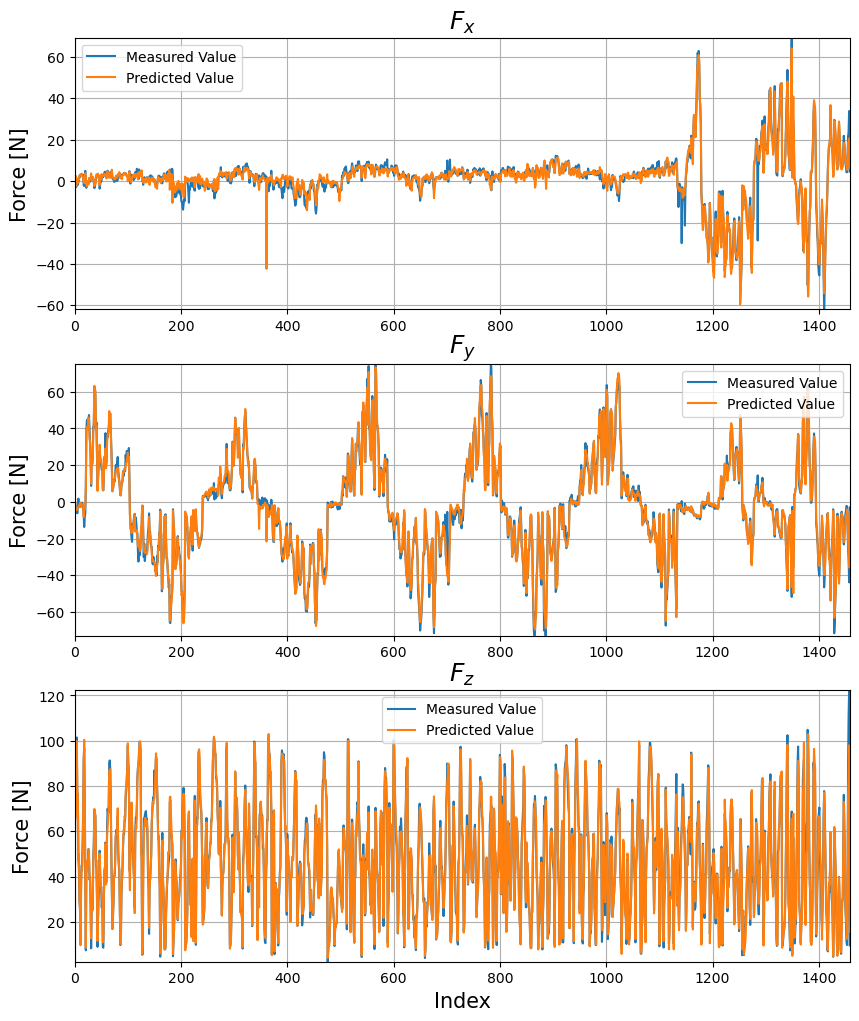

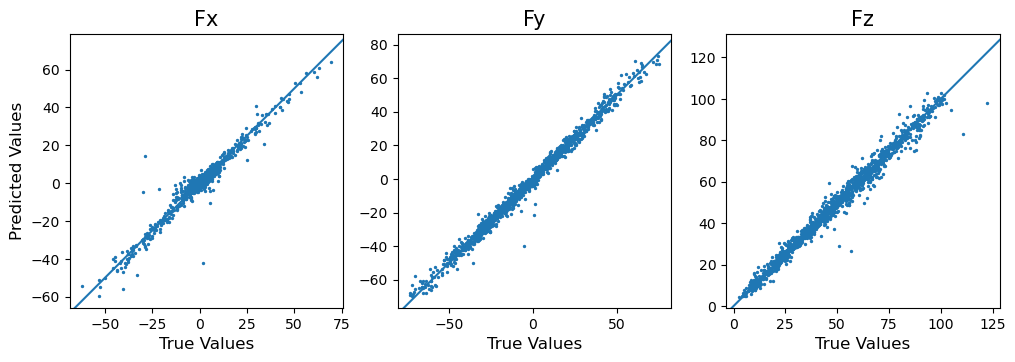

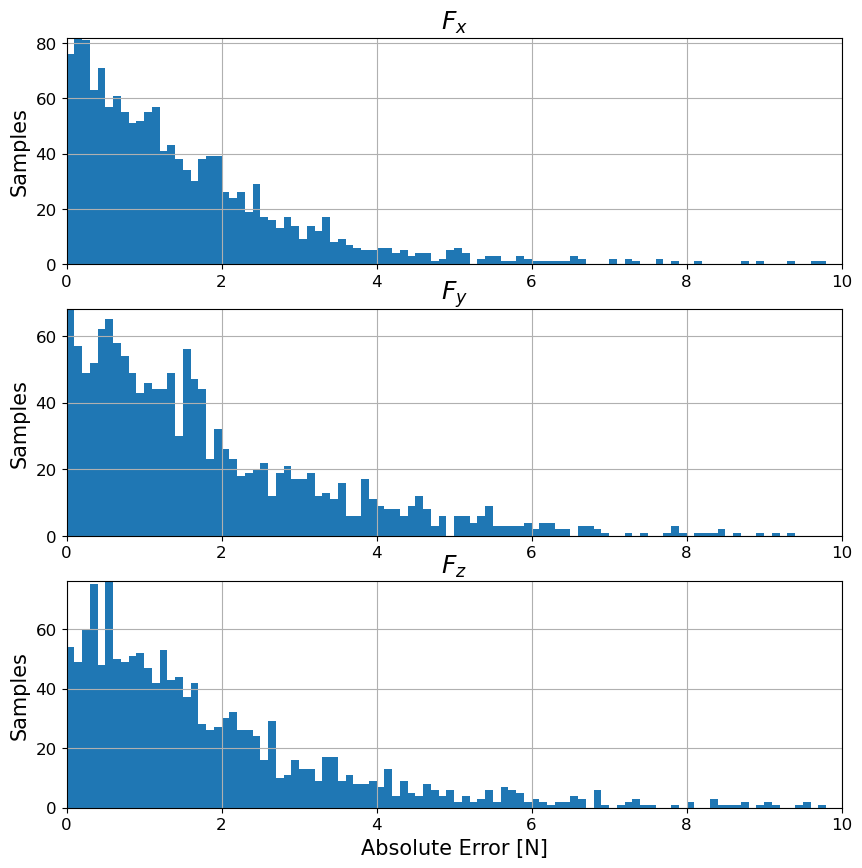

In [28]:
plot_time_diff(df_error_val, titles=['Fx', 'Fy', 'Fz'], isTraining=False, saveFig = SAVEPLOTS, filename=f'{MODELNAME}_Val_timeseries')
plot_multi_diff(df_error_val, titles=['Fx', 'Fy', 'Fz'], saveFig = SAVEPLOTS, filename=f'{MODELNAME}_Val_scatter')
plot_percentage_error_hist(df_error_val, titles=['Fx', 'Fy', 'Fz'], saveFig = SAVEPLOTS, filename=f'{MODELNAME}_Val_Error_scatter')

## Plotting Test Data

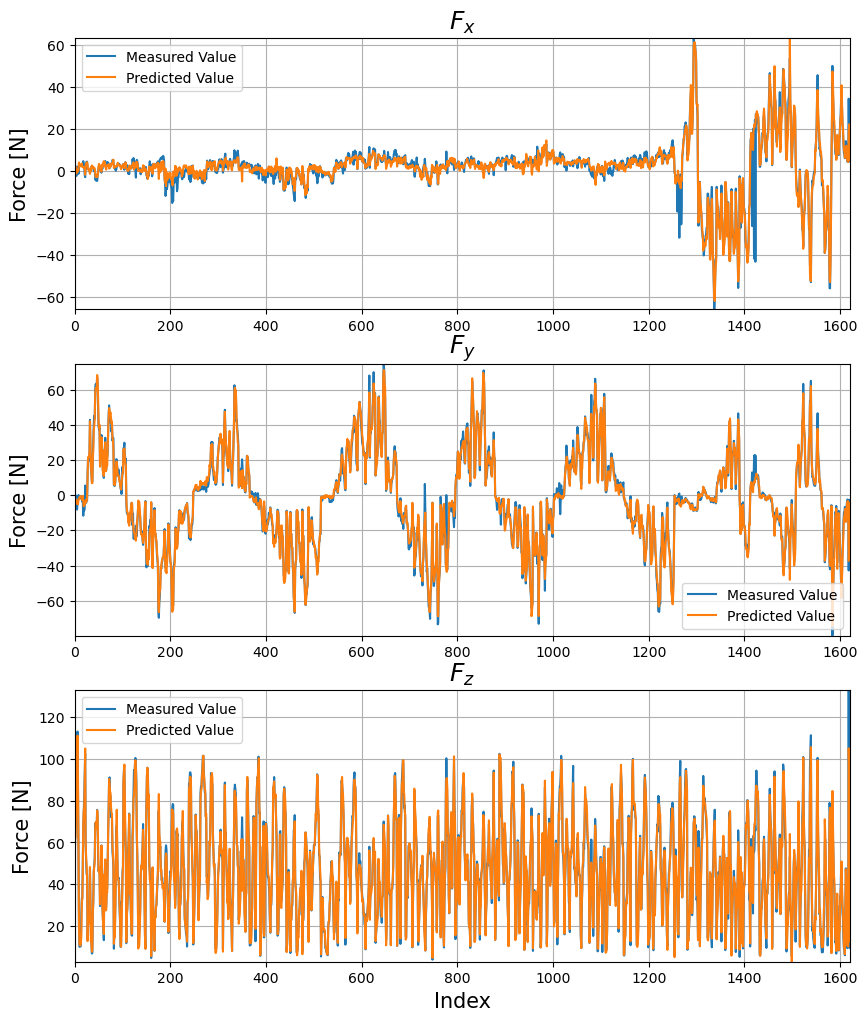

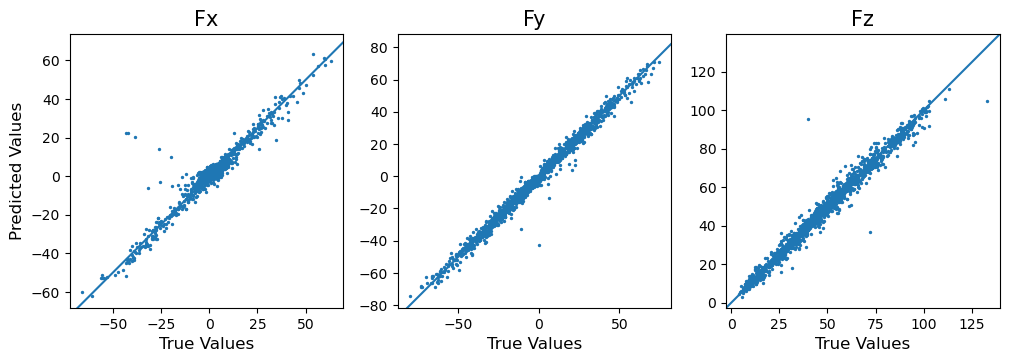

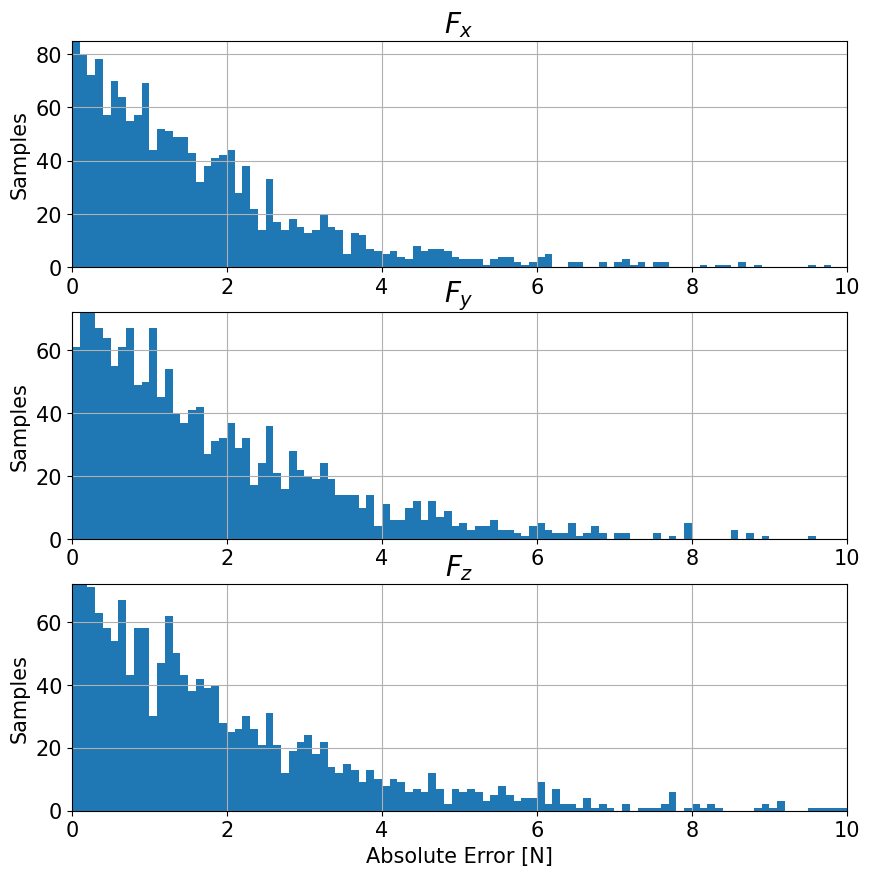

In [33]:
plot_time_diff(df_error_test, titles=['Fx', 'Fy', 'Fz'], isTraining=False, saveFig = SAVEPLOTS, filename=f'{MODELNAME}_Test_timeseries')
plot_multi_diff(df_error_test, titles=['Fx', 'Fy', 'Fz'], saveFig = SAVEPLOTS, filename=f'{MODELNAME}_Test_scatter')
plot_percentage_error_hist(df_error_test, titles=['Fx', 'Fy', 'Fz'], saveFig = SAVEPLOTS, filename=f'{MODELNAME}_Test_Error_scatter_hist')

In [29]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'valdation'], loc='upper left')
plt.grid(True)
if SAVEPLOTS:
    plt.savefig(f'figure/force/force_val_loss.svg')
plt.show()

NameError: name 'history' is not defined

## Plotting figures based on MCU performance

In [ ]:
# df = pd.read_csv('model_tested_1000.csv')


# df = df.sort_values('DisplayName')
# df['inference_us'] = [901, 892, 735,688, 883, 630, 901,1663, 1930 ]

# print(df)



# # df.to_csv('model_tested_1000.csv', index=False)

In [ ]:
# import matplotlib.pyplot as plt
# plt.rcParams["font.size"] = "10"

# # Sort the DataFrame by 'Val_loss' column in ascending order
# df_sorted = df.sort_values('Val_loss')

# # Select the 10 lowest values
# df_top_10 = df_sorted.head(10)

# # Plotting the scatter plots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# # Scatter plot for 'inference_us' against 'Val_loss'
# for index, row in df_top_10.iterrows():
#     ax1.scatter(row['inference_us'], row['Val_loss'], marker='o', label=row['DisplayName'])
# ax1.set_xlabel('Inference speed [$\mu$s]', fontsize = 12)
# ax1.set_ylabel('Validation loss', fontsize = 12)
# ax1.set_title('Inference speed [$\mu$s] vs Validaiton loss', fontsize = 15)
# ax1.legend()

# # Scatter plot for 'inference_us' against 'Size'
# for index, row in df_top_10.iterrows():
#     ax2.scatter(row['inference_us'], row['Size'], marker='o', label=row['DisplayName'])
# ax2.set_xlabel('Inference speed [$\mu$s]', fontsize = 12)
# ax2.set_ylabel('Size', fontsize = 12)
# ax2.set_title('Inference speed [$\mu$s] vs Size', fontsize = 15)
# ax2.legend()

# # Adjusting spacing between subplots
# plt.tight_layout()
# plt.savefig('figure/force/force_infernece.svg')

# # Displaying the subplots
# plt.show()


In [ ]:
# # Sort the DataFrame by 'Val_loss' column in ascending order
# df_sorted = df.sort_values('Val_loss')

# # Select the 10 lowest values
# df_top_10 = df_sorted.head(10)
# print(df_top_10)
# print(df_top_10['DisplayName'])

# # Plot the 10 lowest values against 'Params' with legend
# plt.figure(figsize=(10, 6))
# for index, row in df_top_10.iterrows():
#     plt.plot(row['Size'], row['Val_loss'], marker='o', label=row['DisplayName'])
# plt.xlabel('Parameters', fontsize = 15)
# plt.ylabel('Validation Loss', fontsize = 15)
# plt.title('Validation Loss vs Network Size', fontsize = 20)
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.legend()
# plt.savefig('figure/force/force_val_size.svg')
# plt.show()